In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer,  mean_absolute_error

from scipy.stats.distributions import uniform

In [34]:
def createPreprocessingPipeline():
    preprocPipeline = make_pipeline(
        StandardScaler(with_mean=True, with_std=True)
    )
    
    return preprocPipeline

def createModelPipeline(metricsScorer = None):
    
    paramDistributions = {
        "reg_alpha": uniform(0.0, 1.0),
        "reg_lambda": uniform(0.0, 1.0)
    }
    
    staticParams =  {
        "max_depth": 3,
        "learning_rate": 0.1,
        "n_estimators": 1000,
        "silent": True,
        "objective": 'reg:linear', 
        "booster":'gbtree', 
        "n_jobs": 7, 
        "gamma" : 0, 
        "min_child_weight" : 1, 
        "max_delta_step": 0, 
        "subsample" : 1, 
        "colsample_bytree" : 1, 
        "colsample_bylevel":1, 
        "reg_alpha":0, 
        "reg_lambda":1, 
        "scale_pos_weight":1, 
        "base_score":0.5  
    }
    
    # normalize features
    modelPipeline = make_pipeline(
        RandomizedSearchCV(
            estimator = xgb.XGBRegressor(**staticParams),
            param_distributions = paramDistributions,
            n_iter=3,
            scoring = metricsScorer, 
            return_train_score=True,
            refit=True
        ),
       
    )
    
    return modelPipeline

In [6]:
trainingDataPath = "D:/data/kaggle/PUBG/train.csv"
scoringDataPath = "D:/data/kaggle/PUBG/test.csv"

In [7]:
trainingData = pd.read_csv(trainingDataPath)
scoringData = pd.read_csv(scoringDataPath)

In [19]:
# split into train and test
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    trainingData.drop("winPlacePerc", axis="columns"), 
    trainingData["winPlacePerc"],
    train_size = 0.7,
    shuffle= True
)

C:\Users\Ulric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
print(X_train_validation.shape[0], X_test.shape[0])

3050135 1307201


In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_validation, 
    y_train_validation,
    train_size = 0.7,
    shuffle= True
)

C:\Users\Ulric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
print(X_train.shape[0], X_validation.shape[0])

2135094 915041


# Learning curves

Vary the data size as we train a model
* training error
* test error


In [9]:
preprocessingPipeline = createPreprocessingPipeline()

In [35]:
xgbPipeline = createModelPipeline(
    metricsScorer =make_scorer(score_func=mean_absolute_error, greater_is_better=False)
)

In [24]:
def fitModelPipeline(preprocessingPipeline, modelPipeline, selectedFeatures, X, y, Xtest, ytest):
    
    # run preprocessing pipeline on raw data
    fittedPreprocessingPipeline = preprocessingPipeline.fit(X.loc[:, selectedFeatures], y)
    
    X_processed = fittedPreprocessingPipeline.transform(X.loc[:, selectedFeatures])
    Xtest_processed = fittedPreprocessingPipeline.transform(Xtest.loc[:, selectedFeatures])
    
    eval_set = [
        (X_processed, y), 
        (Xtest_processed, ytest)
    ]
    
    # run the model fitting pipeline on the processed data
    fittedModelPipeline = modelPipeline.fit(
        X_processed, 
        y,
        # xgb options
        randomizedsearchcv__verbose=0,
        randomizedsearchcv__eval_metric="mae",
        randomizedsearchcv__eval_set = eval_set,
        randomizedsearchcv__early_stopping_rounds=5
    )

    # Print out some common eval metrics
    cvResults = fittedModelPipeline.named_steps.get('randomizedsearchcv')
    
    print("best estimator")
    print(cvResults.best_estimator_)
    
    print("best score")
    print(cvResults.best_score_)
    
    print("early stopping")
    print("num trees = %i" % cvResults.best_estimator_.best_ntree_limit)
    print("best score = %i" % cvResults.best_estimator_.best_score)
    print("best iteration = %i" % cvResults.best_estimator_.best_iteration)
    
    
    # return the fitted preprocessing and modeling pipelines
    return fittedPreprocessingPipeline, fittedModelPipeline, cvResults


def evalModel(y_true, y_pred, metric_function):
        
    result = metric_function(y_true, y_pred)    
    return result

#### Preprocess data

In [23]:
fittedPreprocessing = preprocessingPipeline.fit(X_train, y_train)
X_train_processed = fittedPreprocessing.transform(X_train)
X_validation_processed = fittedPreprocessing.transform(X_validation)

In [36]:
fittedPreprocessing, fittedModel, cvResults = fitModelPipeline(
            preprocessingPipeline=preprocessingPipeline,
            modelPipeline=xgbPipeline, 
            selectedFeatures=[
                'assists', 'boosts', 'damageDealt', 'DBNOs',
                'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
                'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
                'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
                'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'
            ], 
            X=X_train[:100], 
            y=y_train[:100],
            Xtest=X_validation[:100],
            ytest=y_validation[:100]
        )

best estimator
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=7, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.33157548621542787, reg_lambda=0.38776811865252303,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)
best score
-0.110056599324
early stopping
num trees = 80
best score = 0
best iteration = 79


In [26]:
cvResults.cv_results_.keys()

dict_keys(['param_reg_lambda', 'split1_test_score', 'split2_train_score', 'mean_train_score', 'split0_train_score', 'split0_test_score', 'std_fit_time', 'split2_test_score', 'param_reg_alpha', 'mean_score_time', 'std_test_score', 'std_score_time', 'mean_fit_time', 'split1_train_score', 'params', 'mean_test_score', 'rank_test_score', 'std_train_score'])

In [37]:
pd.DataFrame(cvResults.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_reg_alpha,param_reg_lambda,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.015657,0.000999,-0.117095,-0.076464,0.712581,0.688117,"{'reg_alpha': 0.712580647881, 'reg_lambda': 0....",3,-0.117137,-0.079550,-0.096481,-0.073621,-0.137664,-0.076222,0.001699,1.123916e-07,0.016729,0.002426
1,0.022321,0.000666,-0.110057,-0.051469,0.331575,0.387768,"{'reg_alpha': 0.331575486215, 'reg_lambda': 0....",1,-0.103850,-0.051395,-0.101454,-0.049752,-0.125054,-0.053260,0.005309,4.711456e-04,0.010571,0.001433
2,0.014991,0.000000,-0.110370,-0.052377,0.346652,0.201472,"{'reg_alpha': 0.346651947196, 'reg_lambda': 0....",2,-0.104530,-0.052953,-0.099892,-0.051169,-0.126865,-0.053008,0.000816,0.000000e+00,0.011731,0.000854


In [38]:
cvResults.cv_results_.get("mean_train_score")

array([-0.07646438, -0.05146868, -0.05237657])

In [39]:
cvResults.cv_results_.get("mean_test_score")

array([-0.11709454, -0.1100566 , -0.11037021])

In [40]:
cvResults.cv_results_.get("params")

[{'reg_alpha': 0.71258064788099928, 'reg_lambda': 0.68811747454400063},
 {'reg_alpha': 0.33157548621542787, 'reg_lambda': 0.38776811865252303},
 {'reg_alpha': 0.34665194719604631, 'reg_lambda': 0.20147191317249691}]

In [41]:
cvResults.best_params_

{'reg_alpha': 0.33157548621542787, 'reg_lambda': 0.38776811865252303}

In [42]:
cvResults.best_score_

-0.11005659932374953

In [51]:
def fitLearningCurves(sampleSizeList, selectedFeatures, X, y, X_validation, y_validation, X_test, y_test):
    
    results = []
    
    for sampleSize in sampleSizeList:
        
        print("="*50)
        print("Sample Size = %i" % sampleSize)
        
        fittedPreprocessing, fittedModel, cvResults = fitModelPipeline(
            preprocessingPipeline=preprocessingPipeline,
            modelPipeline=xgbPipeline, 
            selectedFeatures=[
                'assists', 'boosts', 'damageDealt', 'DBNOs',
                'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
                'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
                'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
                'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'
            ], 
            X=X_train[:sampleSize], 
            y=y_train[:sampleSize],
            Xtest=X_validation,
            ytest=y_validation
        )
        
        modelCvResults = pd.DataFrame(cvResults.cv_results_)
        
        bestModelCvResults = modelCvResults.loc[modelCvResults["rank_test_score"] == 1, ["mean_train_score", "mean_test_score"]]
        assert bestModelCvResults.shape[0] == 1
    
        # Get test score
        X_test_processed = fittedPreprocessing.transform(X_test.loc[:, selectedFeatures])
        y_test_preds = fittedModel.predict(X_test_processed)
                    
        bestModelCvResults["holdout_test_score"] = evalModel(y_test, y_test_preds, mean_absolute_error)
        bestModelCvResults["sample_size"] = sampleSize
        
        results.append(bestModelCvResults)
        
    return pd.concat(results)

In [52]:
selectedFeatures = [
    'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'
    
]

In [61]:
list(range(1000, 510000, 100000))

[1000, 101000, 201000, 301000, 401000, 501000]

In [65]:
learningCurveData = fitLearningCurves(
    range(1000, 510000, 100000), 
    selectedFeatures, 
    X_train, y_train, 
    X_validation, y_validation, 
    X_test, y_test
)

best estimator
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=7, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.43211632662244692, reg_lambda=0.72579802029611418,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)
best score
-0.07999232273
early stopping
num trees = 120
best score = 0
best iteration = 119
best estimator
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=7, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.64460102723952073, reg_lambda=0.0089625714356178499,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)
best score
-0.0642703344718
early sto

# We want a sample size of 300,000 to stabilize the error

In [67]:
learningCurveData

,mean_train_score,mean_test_score,holdout_test_score,sample_size
2,-0.054516,-0.079992,0.079801,1000
0,-0.062126,-0.064270,0.064280,101000
0,-0.062525,-0.063920,0.064203,201000
2,-0.062737,-0.063771,0.063606,301000
1,-0.062973,-0.063769,0.063762,401000
2,-0.063041,-0.063706,0.063620,501000


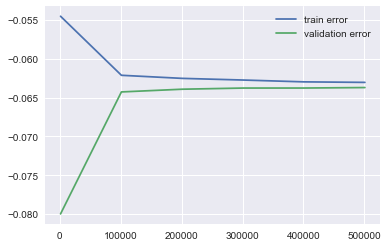

In [69]:
plt.plot(learningCurveData.sample_size, learningCurveData.mean_train_score, label="train error")
plt.plot(learningCurveData.sample_size, learningCurveData.mean_test_score, label="validation error")
plt.legend()

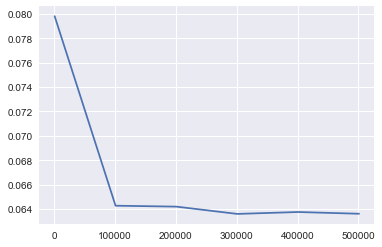

In [70]:
plt.plot(learningCurveData.sample_size, learningCurveData.holdout_test_score, label="test error")